In [1]:
# Regression of one time series (ts) onto a field with lead lag years. field leads ts
# by '-ly' years. And do block bootstrap significant test 
# the output is for one lead-lag year: lead year '-ly'

length=6 # -5,....0 year
ly = -5
variable = 't310'
block_length=4
n_resamples=1000
confidence_level=0.95

import pandas as pd
import xarray as xr
import numpy as np

# read data
data       = xr.open_dataset("/work/uo1075/u241321/data/u241321/data_cdo/temperature_1969-2019_assi_dt_5000.nc",decode_times=False)
ts = np.load("/work/uo1075/u241321/data/eemd_t310_assi_Norwegian.npy")[2,:]

corr      = xr.open_dataset("/work/uo1075/u241321/data/reg_"+variable+"_T_c2.nc")['__xarray_dataarray_variable__'] 


nyear=ts.size
var = np.mean(np.mean(data['__xarray_dataarray_variable__'], axis=1)[:,0:15,:,:],1)
var_1 = var.stack(spatial=('lat','lon')).dropna(dim="spatial") #time,space
spatial = var_1.coords["spatial"]

y1 = var_1[length-1+ly:nyear+ly-1]
y2 = ts[length-1:nyear-1]

coef = corr[5+ly,:,:].stack(spatial=('lat','lon')).dropna(dim="spatial") #time,space


# regression, center on 4-47, 44 year (start from 0)

# for m in range(0,field.shape[1],1):
#         coe[0,m] = regression(y[5:49], field[0:44,m])
#         coe[1,m] = regression(y[5:49], field[1:45,m])
#         coe[2,m] = regression(y[5:49], field[2:46,m])
#         coe[3,m] = regression(y[5:49], field[3:47,m])
#         coe[4,m] = regression(y[5:49], field[4:48,m])
#         coe[5,m] = regression(y[5:49], field[5:49,m])
 
# Due to technical issue, here use 44 years. Cut the last year.

#  LinearRegression

from sklearn.linear_model import LinearRegression
def regression(x,y):

    coef = LinearRegression(fit_intercept=True).fit(x.reshape(-1, 1), y.values.reshape(-1, 1)).coef_[0,0]
    

    return coef


# bootstrap

def _bootstrap_resample(sample1, sample2, block_length, n_resamples=None, random_state=None):
    """Bootstrap resample the sample."""
   
    np.random.shuffle(sample1.reshape((-1,block_length)))
    rng_state = np.random.get_state()
    np.random.set_state(rng_state)
    np.random.shuffle(sample2.values.reshape((-1,block_length)))
    
    # resamples = sample
    coef = regression(sample1, sample2)
    # bootstrap - each row is a random resample of original observations
    # i = rng_integers(random_state, 0, n, (n_resamples, n))

    # resamples = sample[..., i]
    return coef


def bootstrap(data1, data2, rawcoef, block_length, confidence_level, n_resamples,
              method, random_state=None):
 
    # the 1st dimension of data is time
    # confidence_level: 0.9, 0.95, 0.99...
    # n_resamples: 1000, 10000...
    # method: 'percentile', 'basic', 'bca'
    
    # the original Pearson correlation coefficients 
    coef_raw = rawcoef
 
    theta_hat_b = []

    batch_nominal = n_resamples

    for k in range(0, n_resamples):
        # batch_actual = min(batch_nominal, n_resamples-k)
        # Generate resamples
        resampled_coef_data = []
        # for sample in data:
        resample = _bootstrap_resample(data1, data2, block_length, 
                                           random_state=random_state)
        resampled_coef_data.append(resample)

        # Compute bootstrap distribution of Pearson correlation coefficients
        theta_hat_b.append(resampled_coef_data)
    theta_hat_b = np.concatenate(theta_hat_b, axis=-1)

    # Calculate percentile interval
    alpha = (1 - confidence_level)/2
    if method == 'bca':
        interval = _bca_interval(data, statistic, axis=-1, alpha=alpha,
                                 theta_hat_b=theta_hat_b, batch=batch)
        percentile_fun = _percentile_along_axis
    else:
        interval = alpha, 1-alpha

        def percentile_fun(a, q):
            return np.percentile(a=a, q=q, axis=-1)

    # Calculate confidence interval of statistic
    ci_l = percentile_fun(theta_hat_b, interval[0]*100)
    ci_u = percentile_fun(theta_hat_b, interval[1]*100)
    if method == 'basic':  # see [3]
        theta_hat = statistic(*data, axis=-1)
        ci_l, ci_u = 2*theta_hat - ci_u, 2*theta_hat - ci_l

      
    
    if coef_raw >= ci_u:
        sig = 1
    else:
        if coef_raw <= ci_l:
            sig = -1
        else:
            sig = 0
        
    return coef_raw ,sig

# apply to global filed

from multiprocessing import Pool
from itertools import product
from itertools import starmap

def boots_gridpoint(m):
    
    mode = bootstrap(
         y2, y1[:,m], coef[m], block_length=block_length, confidence_level=confidence_level, 
        n_resamples=n_resamples, method='percentile'
    )

    return mode


# pool = Pool()
# ! python --version

res = Pool().map(boots_gridpoint,np.arange(0,y1.shape[1],1))
re = np.array(res)

# output 
corr = xr.DataArray(re[:,0], dims = ["spatial"], coords = {"spatial":spatial}).unstack()    
sig = xr.DataArray(re[:,1], dims = ["spatial"], coords = {"spatial":spatial}).unstack()    

lat = data['lat']
lon = data['lon']
nlat = lat.size
nlon = lon.size

boot = xr.Dataset(data_vars={'lat': (["lat"], lat.data),
                              'lon':  (["lon"], lon.data),
                              'sig': (["lat", "lon"], sig.values),
                              'corr': (["lat", "lon"], corr.values),})
# corr = correlation["corr"]
boot.to_netcdf("/work/uo1075/u241321/data/boot_reg_"+variable+"_ly"+str(-ly)+"_block"+str(block_length)+"_new.nc") 

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'add_labels'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: linewidths is ignored by contourf
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


Text(0.5, 1.0, ' ')

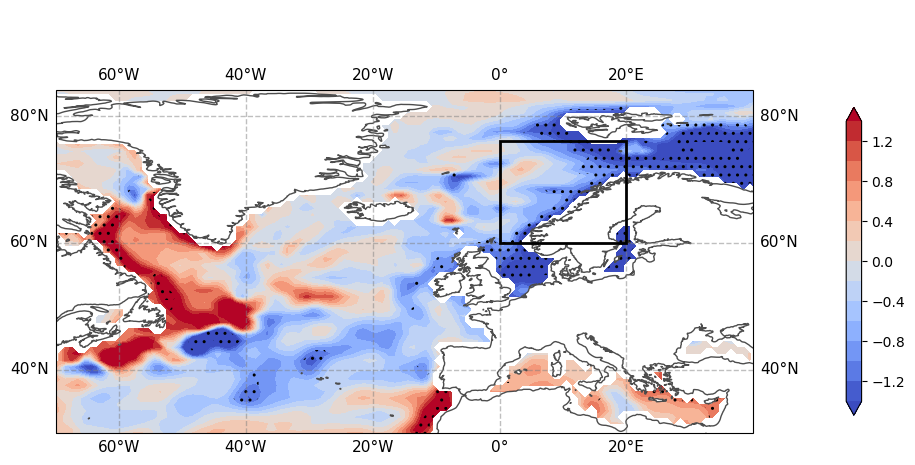

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from xarray import DataArray
import pandas as pd

fig = plt.figure(figsize=(12,5));
ax = plt.axes(projection=ccrs.PlateCarree())

plot1 = ax.contourf(lon, lat, boot['corr'], levels = np.arange(-1.4, 1.6, 0.2), 
                              cmap='coolwarm',
                              extend = 'both', add_colorbar=True, add_labels=False)

plot = ax.contourf(boot['sig'].lon, boot['sig'].lat, abs(boot['sig']),
                      [0, 0.5, 1.1],
                      hatches=[None, '..', None], linewidths=0.5,
                      colors="none", 
                      transform=ccrs.PlateCarree())


#ax.coastlines()
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                                              edgecolor='0.3',
                                              facecolor='1'))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlines = True
gl.ylines = True
ax.set_extent([-70,40,30,80])
gl.xlocator = mticker.FixedLocator(np.arange(-80,90,20))
gl.ylocator = mticker.FixedLocator(np.arange(20,90,20)) #([30,60],180)


gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 11, 'color': 'k','rotation':0}
gl.ylabel_style = {'size':11,'rotation':0}
#plt.title('hello', y=1.08)


# draw box
from matplotlib.patches import Rectangle
    # Get the current reference
# axes = plt.gca()

# Create a Rectangle patch
rect = Rectangle((0,60),20,16,linewidth=2,edgecolor='black',facecolor='none', zorder = 10) # leftbotoom; weith;height
    # Add the patch to the Axes
ax.add_patch(rect)


cbar = plt.colorbar(plot1, orientation='vertical', shrink=0.8, pad = 0.1)
# cbar.set_label(' ', size= 15)
ax.set_title(' ',size = '15', pad = 30)

# fig.savefig('/work/uo1075/u241321/results/plot1.pdf',bbox_inches='tight')
